# 🤖 Robot Deployment - Dobot MG400

**Notebook สำหรับควบคุมแขนกล Dobot MG400**

## สิ่งที่ต้องเตรียมก่อนใช้งาน:

### 1. ⚙️ ติดตั้ง Dependencies
```bash
pip install pydobot
```

### 2. 🎯 Calibration
- ต้องทำ **Camera Calibration** ก่อน!
- ได้ Homography Matrix สำหรับแปลง pixel → robot coordinates
- ดูวิธีใน `ROBOT_DEPLOYMENT_GUIDE.md`

### 3. 🔌 เชื่อมต่อ Robot
- **Windows**: ผ่าน COM port (เช่น `COM3`)
- **Linux**: ผ่าน `/dev/ttyUSB0`
- **Network**: ผ่าน IP address (เช่น `192.168.1.6`)

### 4. ⚠️ Safety
- อ่านคู่มือ Dobot ก่อนใช้งาน!
- ตรวจสอบ workspace ปลอดสิ่งกีดขวาง
- มีคนเฝ้าตลอดเวลา
- พร้อม Emergency Stop

---

## 1️⃣ Setup และ Load Models

In [1]:
!pip install pydobot

  Using cached pydobot-1.3.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached pyserial-3.4-py2.py3-none-any.whl.metadata (1.6 kB)
Using cached pydobot-1.3.2-py3-none-any.whl (7.6 kB)
Using cached pyserial-3.4-py2.py3-none-any.whl (193 kB)

   ---------------------------------------- 0/2 [pyserial]
   ---------------------------------------- 0/2 [pyserial]
   ---------------------------------------- 0/2 [pyserial]
   ---------------------------------------- 0/2 [pyserial]
   ---------------------------------------- 0/2 [pyserial]
   -------------------- ------------------- 1/2 [pydobot]
   -------------------- ------------------- 1/2 [pydobot]
   ---------------------------------------- 2/2 [pydobot]



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

# Import modules
import config
from object_detector import ObjectDetector
from depth_estimator import DepthEstimator
from rule_based_grasp import RuleBasedGraspGenerator
from simple_pipeline import SimplePipeline
from visualization import (
    draw_bounding_boxes,
    draw_grasps,
    create_depth_colormap,
    create_side_by_side,
    add_info_text
)
from robot_control import DobotController

print("✓ Imports loaded")
print(f"Device: {config.DEVICE}")

[Config] Mode: ROBOT, Capture: FRAME_BY_FRAME, Device: cpu


xFormers not available
xFormers not available


✓ Imports loaded
Device: cpu


In [2]:
# Load detection models
print("Loading models...\n")

# 1. Object Detector
print("[1/2] Object Detector (YOLOv8)")
object_detector = ObjectDetector(
    model_name=config.YOLO_MODEL,
    confidence_threshold=config.CONFIDENCE_THRESHOLD,
    device=config.DEVICE
)
object_detector.load_model()

# 2. Depth Estimator
print("\n[2/2] Depth Estimator (DepthAnything V2)")
depth_estimator = DepthEstimator(
    model_name=config.DEPTH_MODEL,
    device=config.DEVICE
)
depth_estimator.load_model(config.DEPTH_MODEL_PATH)

# 3. Grasp Generator
grasp_generator = RuleBasedGraspGenerator(config)

# 4. Create Pipeline
pipeline = SimplePipeline(config)
pipeline.set_components(object_detector, depth_estimator, grasp_generator)

print("\n" + "="*60)
print("✓ Vision system ready!")
print("="*60)

Loading models...

[1/2] Object Detector (YOLOv8)
Loading yolov8n...
✓ Object detector loaded on cpu

[2/2] Depth Estimator (DepthAnything V2)
Loading DepthAnything V2 (vits)...
✓ Depth model loaded on cpu

✓ Vision system ready!


## 2️⃣ Configure Robot Connection

⚠️ **สำคัญ**: แก้ไขค่าต่อไปนี้ให้ตรงกับระบบของคุณ!

In [45]:
# =================================================================
# Robot Configuration - แก้ไขส่วนนี้!
# =================================================================

# 1. Port/IP สำหรับเชื่อมต่อ robot
#ROBOT_PORT = 'COM3'  # Windows: COM3, COM4, ...
#ROBOT_PORT = '/dev/ttyUSB0'  # Linux
ROBOT_PORT = '192.168.1.6'  # IP address

# 2. Homography Matrix (จาก camera calibration)
# ⚠️ ต้องทำ calibration ก่อน! ดูวิธีใน ROBOT_DEPLOYMENT_GUIDE.md

"""
HOMOGRAPHY_MATRIX = np.array([
    [1.2,  0.01, -150],   # แก้ไขให้ตรงกับการ calibrate จริง
    [0.02, 1.3,   200],
    [0.0001, 0.0002, 1]
], dtype=np.float32)
"""

HOMOGRAPHY_MATRIX = np.array([[-0.8109726073613595, 0.004569795459706816, 326.50941812048296], [-0.006018037849237285, -0.8204515705407466, 264.8264090475425], [-5.057174663224671e-05, -4.856213695371979e-05, 1.0]], dtype=np.float32)

# หรือโหลดจากไฟล์:
# HOMOGRAPHY_MATRIX = np.load('calibration/homography.npy')

# 3. Robot Heights (mm)
SAFE_HEIGHT = 90    # ความสูงปลอดภัย (เหนือ workspace)
GRASP_HEIGHT = 20    # ความสูงในการจับวัตถุ

# 4. Drop Position (ตำแหน่งวางวัตถุ)
DROP_X = 250  # mm
DROP_Y = 150  # mm
DROP_Z = 50   # mm
DROP_R = 0    # degrees

print("✓ Robot configuration loaded")
print(f"  Port: {ROBOT_PORT}")
print(f"  Safe height: {SAFE_HEIGHT} mm")
print(f"  Grasp height: {GRASP_HEIGHT} mm")
print(f"  Drop position: ({DROP_X}, {DROP_Y}, {DROP_Z})")

✓ Robot configuration loaded
  Port: 192.168.1.6
  Safe height: 90 mm
  Grasp height: 20 mm
  Drop position: (250, 150, 50)


## 3️⃣ Connect to Robot

⚠️ เปิด robot และตรวจสอบความปลอดภัยก่อน!

In [ ]:
!pip install dobotapi

In [94]:
# ไม่เช็ค error (เก่าแต่ใช้ได้)
import socket
import threading
import numpy as np
import time

class DobotControllerTCP:
    def __init__(self, config=None, homography_matrix=None):
        self.dashboard_port = 29999
        self.sock_dashboard = None
        self.homography_matrix = homography_matrix
        
        # Default Settings
        self.safe_height = 90
        self.grasp_height = 20
        self.drop_pos = (250, 0, 50, 0)
        
    def connect(self, ip_address):
        try:
            self.ip_address = ip_address
            self.sock_dashboard = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            self.sock_dashboard.settimeout(5)
            self.sock_dashboard.connect((self.ip_address, self.dashboard_port))
            
            print("Status: Clearing Errors...")
            self.send_command("ClearError()") 
            time.sleep(0.5)
            
            print("Status: Enabling Robot...")
            self.send_command("EnableRobot()") 
            time.sleep(4)
            
            # Reset User/Tool Frame (สำคัญมาก! เพื่อให้พิกัดตรงกับความเป็นจริง)
            self.send_command("User(0)")
            self.send_command("Tool(0)")
            self.send_command("SpeedFactor(50)")
            
            return True
        except Exception as e:
            print(f"TCP Connection Error: {e}")
            return False

    def send_command(self, string_cmd):
        if self.sock_dashboard:
            try:
                cmd = str(string_cmd) + "\n"
                self.sock_dashboard.send(cmd.encode("utf-8"))
                response = self.sock_dashboard.recv(1024).decode("utf-8")
                return response
            except Exception as e:
                print(f"Send Command Error: {e}")
                return None
        return None

    def home(self):
        print("🤖 Moving to HOME position...")
        self.send_command("JointMovJ(0,0,0,0)")
        time.sleep(4)
        print("✅ Arrived at HOME")

    def transform_camera_to_robot(self, u, v):
        if self.homography_matrix is None:
            return None, None
        point = np.array([u, v, 1], dtype=np.float32)
        robot_point = np.dot(self.homography_matrix, point)
        x_rob = robot_point[0] / robot_point[2]
        y_rob = robot_point[1] / robot_point[2]
        return x_rob, y_rob

    def toggle_suction(self, state):
        val = 1 if state else 0
        self.send_command(f"DO(1,{val})") 
        time.sleep(0.5)

    def check_reply(self, cmd_name, response):
        """เช็คว่าหุ่นยนต์ตอบกลับมาว่า Error หรือไม่"""
        if not response or response.startswith("0") == False:
            print(f"⚠️ Robot ERROR at {cmd_name}: {response.strip()}")
            return False
        return True

    def execute_grasp(self, grasp, confirm=True):
        if grasp is None:
            print("❌ Invalid grasp data")
            return False

        u, v = grasp.center
        angle = grasp.angle
        target_x, target_y = self.transform_camera_to_robot(u, v)
        
        print("\n" + "="*40)
        print(f"🎯 Execution Plan:")
        print(f"   Robot Pos: ({target_x:.1f}, {target_y:.1f}) mm")
        print("="*40)

        if confirm:
            # แก้ไข: ไม่ต้องรอ Input เพื่อลดปัญหา UX, หรือพิมพ์ y ในช่องด้านบน
            ans = input("⚠️ CONFIRM (y/n): ") 
            if ans.lower() != 'y':
                return False

        # --- 1. Move to Safe Height (ใช้ MovJ!) ---
        # ใช้ MovJ (Joint) แทน MovL เพื่อแก้ปัญหา Singularity หรือติด Limit เวลามาจาก Home
        print(f"1. Approaching (MovJ) Z={self.safe_height}...")
        res = self.send_command(f"MovJ({target_x},{target_y},{self.safe_height},{angle})")
        if not self.check_reply("Approach", res): return False
        time.sleep(3)

        # --- 2. Go Down (MovL) ---
        print(f"2. Descending (MovL) Z={self.grasp_height}...")
        res = self.send_command(f"MovL({target_x},{target_y},{self.grasp_height},{angle})")
        if not self.check_reply("Descend", res): return False
        time.sleep(2)

        # --- 3. Suction ON ---
        print("3. Suction ON...")
        self.toggle_suction(True)
        
        # --- 4. Lift Up (MovL) ---
        print("4. Lifting up...")
        res = self.send_command(f"MovL({target_x},{target_y},{self.safe_height},{angle})")
        time.sleep(2)

        # --- 5. Move to Drop Position (MovJ) ---
        dx, dy, dz, dr = self.drop_pos
        print(f"5. Moving to Drop ({dx}, {dy})...")
        res = self.send_command(f"MovJ({dx},{dy},{dz},{dr})") # ใช้ MovJ เดินทางไกลๆ ปลอดภัยกว่า
        time.sleep(4)

        # --- 6. Release ---
        print("6. Releasing...")
        self.toggle_suction(False)
        time.sleep(1)
        
        print("🎉 Finished.")
        return True

    def set_heights(self, safe_h, grasp_h):
        self.safe_height = safe_h
        self.grasp_height = grasp_h

    def set_drop_position(self, x, y, z, r):
        self.drop_pos = (x, y, z, r)

In [95]:
# class เช็ค error ดีมากๆ
import socket
import threading
import numpy as np
import time
import math

class DobotControllerTCP:
    def __init__(self, config=None, homography_matrix=None):
        self.dashboard_port = 29999
        self.sock_dashboard = None
        self.homography_matrix = homography_matrix
        
        # Setting
        self.safe_height = 90
        self.grasp_height = 20 # <-- ถ้าหัวดูดสั้น ให้เพิ่มค่านี้เป็น 40-50
        self.drop_pos = (250, 0, 50, 0)
        
        # Limit การทำงาน (กันไม่ให้ชนฐาน)
        self.MIN_RADIUS = 180 # mm (ห้ามใกล้กว่านี้)
        self.MAX_RADIUS = 450 # mm (ห้ามไกลกว่านี้)
        
    def connect(self, ip_address):
        try:
            self.ip_address = ip_address
            self.sock_dashboard = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            self.sock_dashboard.settimeout(5)
            self.sock_dashboard.connect((self.ip_address, self.dashboard_port))
            
            print("Status: Clearing Errors...")
            self.send_command("ClearError()") 
            time.sleep(0.5)
            
            print("Status: Enabling Robot...")
            self.send_command("EnableRobot()") 
            time.sleep(4)
            
            self.send_command("User(0)")
            self.send_command("Tool(0)")
            self.send_command("SpeedFactor(50)")
            return True
        except Exception as e:
            print(f"TCP Connection Error: {e}")
            return False

    def send_command(self, string_cmd):
        if self.sock_dashboard:
            try:
                cmd = str(string_cmd) + "\n"
                self.sock_dashboard.send(cmd.encode("utf-8"))
                response = self.sock_dashboard.recv(1024).decode("utf-8")
                return response
            except Exception as e:
                print(f"Send Command Error: {e}")
                return None
        return None

    def home(self):
        print("🤖 Moving to HOME position...")
        self.send_command("JointMovJ(0,0,0,0)")
        time.sleep(4)
        print("✅ Arrived at HOME")

    def transform_camera_to_robot(self, u, v):
        if self.homography_matrix is None:
            return None, None
        point = np.array([u, v, 1], dtype=np.float32)
        robot_point = np.dot(self.homography_matrix, point)
        x_rob = robot_point[0] / robot_point[2]
        y_rob = robot_point[1] / robot_point[2]
        return x_rob, y_rob

    def toggle_suction(self, state):
        val = 1 if state else 0
        self.send_command(f"DO(1,{val})") 
        time.sleep(0.5)

    def check_reply(self, cmd_name, response):
        if not response or response.startswith("0") == False:
            print(f"⚠️ Robot ERROR at {cmd_name}: {response.strip()}")
            return False
        return True

    def execute_grasp(self, grasp, confirm=True):
        if grasp is None:
            print("❌ Invalid grasp data")
            return False

        u, v = grasp.center
        angle = grasp.angle
        target_x, target_y = self.transform_camera_to_robot(u, v)
        
        # --- ตรวจสอบระยะ (Safety Check) ---
        radius = math.sqrt(target_x**2 + target_y**2)
        print("\n" + "="*40)
        print(f"🎯 Execution Plan:")
        print(f"   Robot Pos: ({target_x:.1f}, {target_y:.1f}) mm")
        print(f"   Distance from Base: {radius:.1f} mm")
        
        if radius < self.MIN_RADIUS:
            print(f"❌ ERROR: Object is too close! (< {self.MIN_RADIUS}mm)")
            print("   -> Move object further away.")
            return False
        if radius > self.MAX_RADIUS:
            print(f"❌ ERROR: Object is too far! (> {self.MAX_RADIUS}mm)")
            return False
        print("="*40)

        if confirm:
            ans = input("⚠️ CONFIRM (y/n): ") 
            if ans.lower() != 'y': return False

        # --- Execution ---
        # ใช้ MovJ เพื่อหลบ Singularity
        print(f"1. Approaching Z={self.safe_height}...")
        res = self.send_command(f"MovJ({target_x},{target_y},{self.safe_height},{angle})")
        if not self.check_reply("Approach", res): return False
        time.sleep(3)

        print(f"2. Descending Z={self.grasp_height}...")
        res = self.send_command(f"MovL({target_x},{target_y},{self.grasp_height},{angle})")
        if not self.check_reply("Descend", res): return False
        time.sleep(2)

        print("3. Suction ON...")
        self.toggle_suction(True)
        
        print("4. Lifting up...")
        res = self.send_command(f"MovL({target_x},{target_y},{self.safe_height},{angle})")
        time.sleep(2)

        # Drop Position
        dx, dy, dz, dr = self.drop_pos
        print(f"5. Moving to Drop ({dx}, {dy})...")
        res = self.send_command(f"MovJ({dx},{dy},{dz},{dr})")
        if not self.check_reply("DropMove", res): return False
        time.sleep(4)

        print("6. Releasing...")
        self.toggle_suction(False)
        time.sleep(1)
        
        print("🎉 Finished.")
        return True
    
    # ... (set_heights, set_drop_position เหมือนเดิม) ...
    def set_heights(self, safe_h, grasp_h):
        self.safe_height = safe_h
        self.grasp_height = grasp_h

    def set_drop_position(self, x, y, z, r):
        self.drop_pos = (x, y, z, r)

In [103]:
# =================================================================
# Section 3: Connect (Updated for TCP/IP)
# =================================================================

# เรียกใช้ Class ใหม่ที่สร้างไว้ด้านบน
# config อาจจะไม่จำเป็นต้องใช้ใน TCP mode แบบง่าย แต่ใส่ไว้เพื่อความเข้ากันได้
robot = DobotControllerTCP(config=None, homography_matrix=HOMOGRAPHY_MATRIX)

# Set parameters
robot.set_heights(SAFE_HEIGHT, GRASP_HEIGHT)
robot.set_drop_position(DROP_X, DROP_Y, DROP_Z, DROP_R)

# Connect โดยใช้ IP Address
if robot.connect(ROBOT_PORT):
    print("\n" + "="*60)
    print(f"🤖 Robot connected successfully via TCP/IP to {ROBOT_PORT}!")
    print("="*60)
    
    # ทดสอบส่งคำสั่งเบาๆ เพื่อยืนยัน (Option)
    # robot.send_command("Speed(50)") 
else:
    print("\n⚠️ Failed to connect via TCP/IP.")
    print("  - Check Ethernet cable")
    print("  - Check if Robot IP is actually 192.168.1.6")
    print("  - Ping 192.168.1.6 from command line to verify")

Status: Clearing Errors...
Status: Enabling Robot...

🤖 Robot connected successfully via TCP/IP to 192.168.1.6!


In [ ]:
# กระจอก

# Create robot controller
# 192.168.1.6
robot = DobotController(config, HOMOGRAPHY_MATRIX)

# Set parameters
robot.set_heights(SAFE_HEIGHT, GRASP_HEIGHT)
robot.set_drop_position(DROP_X, DROP_Y, DROP_Z, DROP_R)

# Connect
if robot.connect(ROBOT_PORT):
    print("\n" + "="*60)
    print("🤖 Robot connected successfully!")
    print("="*60)
else:
    print("\n⚠️ Failed to connect. Check:")
    print("  - Robot is powered on")
    print("  - Cable is connected")
    print("  - Port/IP is correct")
    print("  - pydobot is installed")

In [113]:
# Home robot (ไปจุดเริ่มต้น)
print("⚠️ Robot will move to HOME position!")
confirm = input("Continue? (y/n): ")

if confirm.lower() == 'y':
    robot.home()
else:
    print("Cancelled")

⚠️ Robot will move to HOME position!
🤖 Moving to HOME position...
✅ Arrived at HOME


In [114]:
# =================================================================
# MANUAL TEST: ใช้พิกัดจริงจาก Dobot Studio
# =================================================================

# 1. ใส่ค่าพิกัดที่คุณเห็นจาก Dobot Studio (จุดที่หุ่นยนต์ควรไปหยิบ)
REAL_X = 309
REAL_Y = 40

# 2. ใส่ค่า Z (ความสูง)
# จากภาพ Z = -152.79 (แปลว่าโต๊ะอยู่ต่ำกว่าฐานหุ่นยนต์)
# เราต้องตั้งค่า Z ให้สัมพันธ์กัน
OVERRIDE_GRASP_Z = -152.0  # จุดที่ลงไปหยิบ (สูงกว่าพื้นนิดนึง หรือเท่าพื้น)
OVERRIDE_SAFE_Z  = -50.0   # จุดปลอดภัย (ยกขึ้นมาประมาณ 10 ซม.)

print(f"⚠️ MANUAL TEST MODE")
print(f"Target: ({REAL_X}, {REAL_Y})")
print(f"Heights: Grasp={OVERRIDE_GRASP_Z}, Safe={OVERRIDE_SAFE_Z}")

confirm = input("Confirm execute manual coordinates? (y/n): ")

if confirm.lower() == 'y':
    # สร้าง Object Grasp จำลองขึ้นมา
    class MockGrasp:
        pass
    
    # อัปเดตความสูงใน Robot Controller ชั่วคราว
    robot.set_heights(safe_h=OVERRIDE_SAFE_Z, grasp_h=OVERRIDE_GRASP_Z)
    
    # สั่งเคลื่อนที่ด้วย Manual Command (copy logic จาก execute_grasp มาย่อ)
    try:
        # 1. Approach (MovJ)
        print("1. Approaching Safe Z...")
        robot.send_command(f"MovJ({REAL_X},{REAL_Y},{OVERRIDE_SAFE_Z},0)")
        time.sleep(3)
        
        # 2. Go Down (MovL)
        print("2. Descending...")
        robot.send_command(f"MovL({REAL_X},{REAL_Y},{OVERRIDE_GRASP_Z},0)")
        time.sleep(2)
        
        # 3. Suction
        print("3. Suction ON")
        robot.toggle_suction(True)
        time.sleep(1)
        
        # 4. Lift
        print("4. Lifting...")
        robot.send_command(f"MovL({REAL_X},{REAL_Y},{OVERRIDE_SAFE_Z},0)")
        time.sleep(2)
        
        # 5. Drop
        dx, dy, dz, dr = robot.drop_pos
        print(f"5. Going to drop at ({dx}, {dy})...")
        robot.send_command(f"MovJ({dx},{dy},{dz},{dr})")
        time.sleep(4)
        
        # 6. Release
        print("6. Releasing")
        robot.toggle_suction(False)
        
        print("🎉 Manual Test Finished!")
        
    except Exception as e:
        print(f"Error during manual test: {e}")
else:
    print("Cancelled")

⚠️ MANUAL TEST MODE
Target: (309, 40)
Heights: Grasp=-152.0, Safe=-50.0
1. Approaching Safe Z...
2. Descending...
3. Suction ON
4. Lifting...
5. Going to drop at (250, 150)...
6. Releasing
🎉 Manual Test Finished!


## 4️⃣ Test Single Grasp

ทดสอบจับวัตถุ 1 ครั้ง

Capturing image...
✓ Frame captured: (480, 640, 3)

Processing...

Results:
  Objects detected: 1
  Total grasps: 4
  Best grasp quality: 0.561


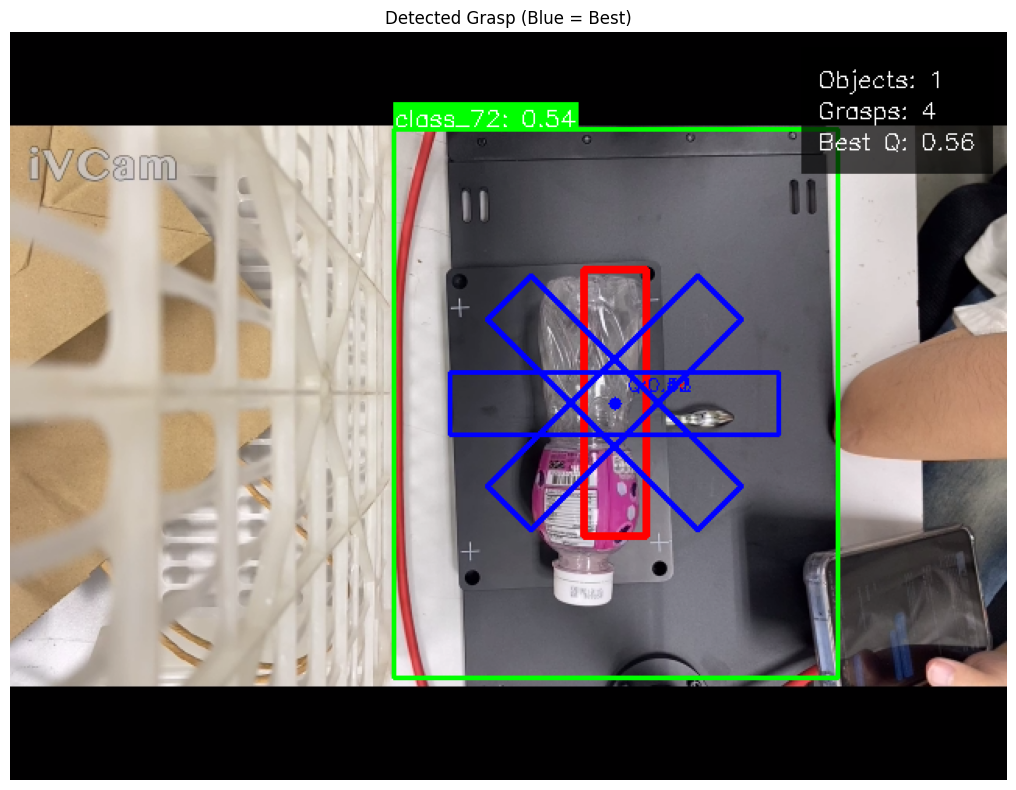

In [83]:
# Capture frame
print("Capturing image...")
cap = cv2.VideoCapture(config.CAMERA_ID)
ret, frame = cap.read()
cap.release()

if not ret:
    print("✗ Failed to capture frame")
else:
    print(f"✓ Frame captured: {frame.shape}")
    
    # Process frame
    print("\nProcessing...")
    result = pipeline.process_frame(frame, detect_objects=True)
    
    # Get best grasp
    best_grasp = pipeline.get_best_grasp(result)
    all_grasps = pipeline.get_all_grasps(result)
    
    print(f"\nResults:")
    print(f"  Objects detected: {len(result['detections'])}")
    print(f"  Total grasps: {len(all_grasps)}")
    
    if best_grasp:
        print(f"  Best grasp quality: {best_grasp.quality:.3f}")
        
        # Visualize
        vis = frame.copy()
        vis = draw_bounding_boxes(vis, result['detections'])
        vis = draw_grasps(vis, all_grasps, best_grasp=best_grasp)
        
        info = {
            'Objects': len(result['detections']),
            'Grasps': len(all_grasps),
            'Best Q': f"{best_grasp.quality:.2f}"
        }
        vis = add_info_text(vis, info)
        
        # Show
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Detected Grasp (Blue = Best)')
        plt.tight_layout()
        plt.show()
        
        # Store for execution
        current_grasp = best_grasp
        current_frame = vis
        
    else:
        print("\n⚠️ No suitable grasp found")
        print("Try:")
        print("  - Better lighting")
        print("  - Larger object")
        print("  - Adjust camera angle")

In [87]:
# Execute the grasp
if 'current_grasp' in locals() and current_grasp is not None:
    print("⚠️ Robot will now execute the grasp!")
    print("Make sure workspace is clear.")
    
    # Execute (จะถามยืนยันอีกครั้งใน function)
    success = robot.execute_grasp(current_grasp, confirm=True)
    
    if success:
        print("\n🎉 Grasp completed successfully!")
    else:
        print("\n⚠️ Grasp failed or cancelled")
else:
    print("No grasp to execute. Run the cell above first.")

⚠️ Robot will now execute the grasp!
Make sure workspace is clear.

🎯 Execution Plan:
   Robot Pos: (139.6, -56.7) mm
   Distance from Base: 150.7 mm
❌ ERROR: Object is too close! (< 180mm)
   -> Move object further away.

⚠️ Grasp failed or cancelled


## 5️⃣ Continuous Operation

รันแบบต่อเนื่อง: Detect → Grasp → Repeat

In [ ]:
# Continuous operation settings
MAX_ITERATIONS = 5        # จำนวนครั้งสูงสุด
MIN_QUALITY = 0.5          # คุณภาพต่ำสุดที่ยอมรับ
DELAY_BETWEEN = 2          # วินาที (รอให้วัตถุถูกเติม)
AUTO_CONFIRM = False       # ถ้า True = ไม่ต้องถามยืนยัน (อันตราย!)

print("Continuous Operation Settings:")
print(f"  Max iterations: {MAX_ITERATIONS}")
print(f"  Min quality: {MIN_QUALITY}")
print(f"  Delay: {DELAY_BETWEEN}s")
print(f"  Auto confirm: {AUTO_CONFIRM}")

In [ ]:
print("\n" + "="*60)
print("🔄 Starting Continuous Operation")
print("="*60)
print("Press Ctrl+C to stop\n")

iteration = 0
success_count = 0
fail_count = 0

try:
    while iteration < MAX_ITERATIONS:
        iteration += 1
        print(f"\n{'='*60}")
        print(f"Iteration {iteration}/{MAX_ITERATIONS}")
        print(f"{'='*60}")
        
        # Capture
        cap = cv2.VideoCapture(config.CAMERA_ID)
        ret, frame = cap.read()
        cap.release()
        
        if not ret:
            print("✗ Failed to capture")
            fail_count += 1
            continue
        
        # Process
        result = pipeline.process_frame(frame, detect_objects=True)
        best_grasp = pipeline.get_best_grasp(result)
        
        if best_grasp is None:
            print("⚠️ No object detected")
            fail_count += 1
            time.sleep(DELAY_BETWEEN)
            continue
        
        if best_grasp.quality < MIN_QUALITY:
            print(f"⚠️ Quality too low: {best_grasp.quality:.3f} < {MIN_QUALITY}")
            fail_count += 1
            time.sleep(DELAY_BETWEEN)
            continue
        
        # Execute
        success = robot.execute_grasp(best_grasp, confirm=not AUTO_CONFIRM)
        
        if success:
            success_count += 1
            print(f"✅ Success! ({success_count}/{iteration})")
        else:
            fail_count += 1
            print(f"❌ Failed ({fail_count}/{iteration})")
        
        # Wait before next iteration
        if iteration < MAX_ITERATIONS:
            print(f"\nWaiting {DELAY_BETWEEN}s...")
            time.sleep(DELAY_BETWEEN)

except KeyboardInterrupt:
    print("\n\n⚠️ Stopped by user")
    robot.emergency_stop()

except Exception as e:
    print(f"\n\n✗ Error: {e}")
    robot.emergency_stop()

finally:
    # Summary
    print("\n" + "="*60)
    print("📊 Summary")
    print("="*60)
    print(f"Total iterations: {iteration}")
    print(f"Successful: {success_count} ({success_count/max(iteration,1)*100:.1f}%)")
    print(f"Failed: {fail_count} ({fail_count/max(iteration,1)*100:.1f}%)")
    print("="*60)

## 6️⃣ Manual Control

สำหรับทดสอบการเคลื่อนที่แบบ manual

In [54]:
# Get current position
pos = robot.get_current_position()
if pos:
    print(f"Current position: X={pos[0]:.1f}, Y={pos[1]:.1f}, Z={pos[2]:.1f}, R={pos[3]:.1f}")
else:
    print("Not connected")

AttributeError: 'DobotControllerTCP' object has no attribute 'get_current_position'

In [ ]:
# Move to specific position (แก้ไขค่าตามต้องการ)
X = 250
Y = 0
Z = 100
R = 0

print(f"Moving to: ({X}, {Y}, {Z}, {R})")
robot.move_to(X, Y, Z, R)

In [ ]:
# Test gripper
print("Opening gripper...")
robot.control_gripper(close=False)
time.sleep(1)

print("Closing gripper...")
robot.control_gripper(close=True)
time.sleep(1)

print("Opening gripper...")
robot.control_gripper(close=False)

## 7️⃣ Cleanup

⚠️ รันเมื่อเสร็จสิ้นการใช้งาน

In [ ]:
# Home robot
print("Homing robot...")
robot.home()

# Disconnect
print("Disconnecting...")
robot.disconnect()

print("\n✓ Cleanup complete!")

---

## 📝 Notes

### เมื่อมีปัญหา:

1. **Robot ไม่เชื่อมต่อ**
   - ตรวจสอบ port/IP
   - Restart robot
   - ตรวจสอบว่า pydobot ติดตั้งแล้ว

2. **Robot จับพลาด (ตำแหน่งผิด)**
   - ทำ camera calibration ใหม่
   - ตรวจสอบว่า camera ไม่เคลื่อนที่
   - ปรับ HOMOGRAPHY_MATRIX

3. **ไม่ detect วัตถุ**
   - เพิ่มแสง
   - ทำพื้นหลังให้ต่างสีกับวัตถุ
   - ลด CONFIDENCE_THRESHOLD

4. **Grasp quality ต่ำ**
   - ตรวจสอบแสงและพื้นผิว
   - ปรับ DEPTH_VARIANCE_THRESHOLD
   - เพิ่มจำนวน GRASP_ORIENTATIONS

### Safety Reminders:

- ⚠️ อยู่ห่างจาก workspace ขณะ robot ทำงาน
- ⚠️ พร้อม Emergency Stop ตลอดเวลา
- ⚠️ ทดสอบด้วยความเร็วช้าก่อน
- ⚠️ ตรวจสอบ workspace limits

---

**Good luck! 🚀**